This notebook will mimick the continous daily ingestion with outlier detection and linear gapfilling

The notebook assumes a prediction of NDVI values when the data is missing and the recalculation when a new observed data is coming.
It is possible to deactivate the NDVI prediction by commenting this line.

The notebook will give to output
An image with the full time series gapfilled (the results should be identical to L1_historical_smoothing)
A GIF with the mimicking of continuous ingestion and reassignement of predicted NDVI values

To mimick the ingestion data, we required at least two observed data and an inital linear slope. 
For this reason the gapfilling start after the first two observed data are met.

To ease the function and avoid loading unnecessary data, some values per pixel pixel needs to be stored. In particular
threshold for outlier detection by neighbour: up to now hard coded, in future can be saved after the historical gapfilling and updated yearly (or more)
last_position: last position of observed non outlier data. Very important to save since it allows to load the minimum amount of data. Must be updated each time a non outlier data is ingested


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import rioxarray
import zarr
import pandas as pd
from matplotlib.lines import Line2D
import imageio
from io import BytesIO



Parameter
The tunable parameter are
Pixel: select the pixel to perform the analysis
param_iqr: regulate the bandiwth in which a point is considered an outlier
upper and bottom_iqr: regulate the lower and upper threshold absed on the delta to the neighbour values
duration_ingestion: number of step in which the ingestion is done, long ingestion may slow down the GIF creation

In [2]:
pixel = 91
param_iqr = 1.5
upper_iqr = 0.6
bottom_iqr = 0.4
duration_ingestion = 500

This chunk will find the first two observed non-outlier data. It is required to run only if the pixel parameter is changed

In [3]:
ds = xr.open_zarr("../..//sample_seasonal_cycle_parameter_preds.zarr")
ndvi = ds['ndvi']
dates = ds['dates']

params_lower = torch.tensor(ds["params_lower"].values)
params_upper = torch.tensor(ds["params_upper"].values)

# convert dates to doy
dates_pd = pd.to_datetime(dates)

df = pd.DataFrame({
    'date': dates_pd
})

# Sort by date
df_sorted = df.sort_values(by='date')

# Extract the sorted arrays if needed
dates_sorted = df_sorted['date'].values
dates_pd_sorted = pd.to_datetime(dates_sorted)
doy = dates_pd_sorted.dayofyear.values

doy = torch.tensor(doy, dtype=torch.float32)
T_SCALE = 1.0 / 365.0
t = doy.unsqueeze(0).repeat(params_lower.shape[0], 1) * T_SCALE

# Define the double logistic function
def double_logistic_function(t, params):
    sos, mat_minus_sos, sen, eos_minus_sen, M, m = torch.split(params, 1, dim=1)
    mat_minus_sos = torch.nn.functional.softplus(mat_minus_sos)
    eos_minus_sen = torch.nn.functional.softplus(eos_minus_sen)
    sigmoid_sos_mat = torch.nn.functional.sigmoid(
        -2 * (2 * sos + mat_minus_sos - 2 * t) / (mat_minus_sos + 1e-10)
    )
    sigmoid_sen_eos = torch.nn.functional.sigmoid(
        -2 * (2 * sen + eos_minus_sen - 2 * t) / (eos_minus_sen + 1e-10)
    )
    return (M - m) * (sigmoid_sos_mat - sigmoid_sen_eos) + m



# caclulate lower and upper bonds
lower = double_logistic_function(t[[0]], params_lower[[pixel]]).squeeze().cpu().numpy()
upper = double_logistic_function(t[[0]], params_upper[[pixel]]).squeeze().cpu().numpy()
# initialize outlier flag
outlier_arr = np.repeat(False,len(dates))

# extract ndvi 
ndvi_timeseries = ndvi[pixel, :]

# normalization
ndvi_timeseries = ndvi_timeseries / 10000

# assign cloud mask as nan
ndvi_timeseries = np.where((ndvi_timeseries > 1) | (ndvi_timeseries < 0), np.nan, ndvi_timeseries)
dates_pd = pd.to_datetime(dates)

# proper sorting

df = pd.DataFrame({
    'date': dates_pd,
    'ndvi': ndvi_timeseries
    })

df_sorted = df.sort_values(by='date')

dates_sorted = df_sorted['date'].values
ndvi_sorted = df_sorted['ndvi'].values

# initialize ndvi gapfilled
ndvi_gapfilled = np.copy(ndvi_sorted)

valid_idx = np.where(np.isfinite(ndvi_sorted))
valid_ndvi = ndvi_sorted[valid_idx]
valid_idx = np.array(valid_idx[0])
valid_upper = upper[valid_idx]
valid_lower = lower[valid_idx]

iqr = upper - lower
valid_iqr = valid_upper - valid_lower

median = upper - iqr / 2
median_valid = valid_upper - valid_iqr / 2

#######################
## outlier detection ##
#######################

# calculate threshold
delta_threshold_upper = valid_upper + param_iqr * valid_iqr
delta_threshold_lower = valid_lower - param_iqr * valid_iqr

# outlier detection by threshold

deltas = []
is_outlier_threshold = []

for i in range(0,len(valid_idx)):

    if valid_ndvi[i] > valid_upper[i]:

            delta = valid_ndvi[i] - valid_upper[i]

            if valid_ndvi[i] > delta_threshold_upper[i]:
                
                outlier = True
            else:
                outlier = False
    
    elif (valid_ndvi[i] < valid_upper[i]) and (valid_ndvi[i] > valid_lower[i]):
          
        delta = valid_ndvi[i] - (valid_upper[i] - valid_iqr[i])
        outlier = False

    else:
            delta = valid_ndvi[i] - valid_lower[i]

            if valid_ndvi[i] < delta_threshold_lower[i]:
                 
                 outlier = True
            else:
                 outlier = False

    deltas.append(delta)
    is_outlier_threshold.append(outlier)
    
is_outlier_threshold = np.array(is_outlier_threshold)
deltas = np.array(deltas)

# outlier detection by deltas neighbour
# the deltas are calculated based on the neaster bound

delta_delta_left = (deltas[1:] - deltas[:-1]) 
delta_delta_right = (deltas[:-1] - deltas[1:]) 

delta_delta_left = np.array(delta_delta_left)
delta_delta_right = np.array(delta_delta_right)


slope_is_outlier = np.logical_and(
        
        np.logical_or(delta_delta_left[1:] > np.quantile(delta_delta_left,upper_iqr), 
                      delta_delta_left[1:]  <  np.quantile(delta_delta_left,bottom_iqr)),

        np.logical_or(delta_delta_right[:-1]  > np.quantile(delta_delta_right,upper_iqr), 
                      delta_delta_right[:-1]  < np.quantile(delta_delta_right,bottom_iqr))
    )


# to be an outlier, a point must met both conditions
is_outlier = np.logical_and(is_outlier_threshold[1:-1],slope_is_outlier)

# write the outlier in the new data
outlier_arr[valid_idx[1:-1]] = is_outlier

# outlier detection first and last
if np.logical_and(
     
     np.logical_or(
        delta_delta_right[0] >= np.quantile(delta_delta_right,upper_iqr), 
        delta_delta_right[0] <= np.quantile(delta_delta_right,bottom_iqr)
        ),
        
        is_outlier_threshold[0]):

    outlier_arr[valid_idx[0]] = True
    ndvi_gapfilled[valid_idx[0]] = np.nan

if np.logical_and(
                 
        np.logical_or(
            delta_delta_left[-1] >= np.quantile(delta_delta_left,upper_iqr), 
            delta_delta_left[-1] <= np.quantile(delta_delta_left,bottom_iqr)
            ),
            
            is_outlier_threshold[-1]) == True:


    outlier_arr[valid_idx[-1]] = True
    ndvi_gapfilled[valid_idx[-1]] = np.nan

#######################
## linear gapfilling ##
#######################

to_keep = valid_idx[1:-1][is_outlier == False]



/home/francesco/miniconda3/envs/ndvi/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


From this chuck the data ingestion begins.
The following chucks will create teh starting conditions

In [4]:
last_position = to_keep[:2]


starting_pos = last_position[1]

slope = ((ndvi_sorted[starting_pos] - median[starting_pos]) - (ndvi_sorted[last_position[0]] - median[last_position[0]])) / (starting_pos - last_position[0])
last_value = ndvi_sorted[starting_pos]
last_position = starting_pos


This code will initiale and empty array (easy to create a demo, can be changed in future) and simulate the data ingestion with a for cycle

In [ ]:
new_data_list = [7] * (duration_ingestion)
new_outlier_list = [7] * (duration_ingestion)

last_delta = ndvi_sorted[last_position] -median[last_position]

for i in np.arange(starting_pos +1 ,duration_ingestion):
     
    new_data = ndvi_sorted[i]

    if np.isfinite(new_data):

        # check if could be potential outlier

        new_delta = new_data - median[i]

        outlier_new = 0
        
        if (
            (new_data > upper[i] + iqr[i] * param_iqr) or 
            (new_data < lower[i] - iqr[i] * param_iqr)
            ) and (
                (new_delta - last_delta < 0.005) or 
                (new_delta - last_delta > 0.05)
                ):
             
            outlier_new = 2
            potential_delta = new_delta
            potential_position = i
        
        if outlier_new == 0:

            potential_outlier_check = new_outlier_list[last_position:i]

            positions = [i for i, x in enumerate(potential_outlier_check) if x == 2]
             
            # check if the previous value is a potential outlier
            if len(positions) == 1:

                postion = positions[0]
                 
                # calculate deltas, if delta is ok gapfill, otherwise the previous data is outlier
                delta_delta = (new_delta - potential_delta) / (i - potential_position)

                if delta_delta < 0.0005 or delta_delta > 0.005:
                    # previous data is outlier
                    new_outlier_list[postion] = 1

                else:

                    # gapfill and then substitute

                    if i - last_position > 1: # otherwise no gapfilling because are continous
                
                        slope = (new_delta - last_delta) / (i - last_position)
                        multiplier = np.arange(1,(i - last_position))
                        values = median[last_position +1:i] + last_delta + slope * multiplier
                        new_data_list.extend(values) 

                        new_outlier_list[postion] = 0
                        new_data_list[postion] = ndvi_sorted[postion]
                        last_delta = potential_delta
                        last_position = potential_position

            # gapfill 
            if i - last_position > 1: # otherwise no gapfilling because are continous
                
                slope = (new_delta - last_delta) / (i - last_position)
                multiplier = np.arange(1,(i - last_position))
                values = median[last_position +1:i] + last_delta + slope * multiplier
                new_data_list[last_position +1:i] = values
                
            new_data_list[i] = new_data


            last_delta = new_delta
            last_position = i
            
    else:

        
        new_data_list[i] = median[i] + last_delta + slope # comment here to remove NDVI prediction
        outlier_new = 3


    
    new_outlier_list[i] = (outlier_new)


flat_array = np.array(new_data_list)


This code will show the gapfilled data as black point and observed data as green point.
I chose to represent the gapfilled data as points and not as line because the line may create some misuendarting (sharp edges where in reality there are no gapfilled ponts in between)

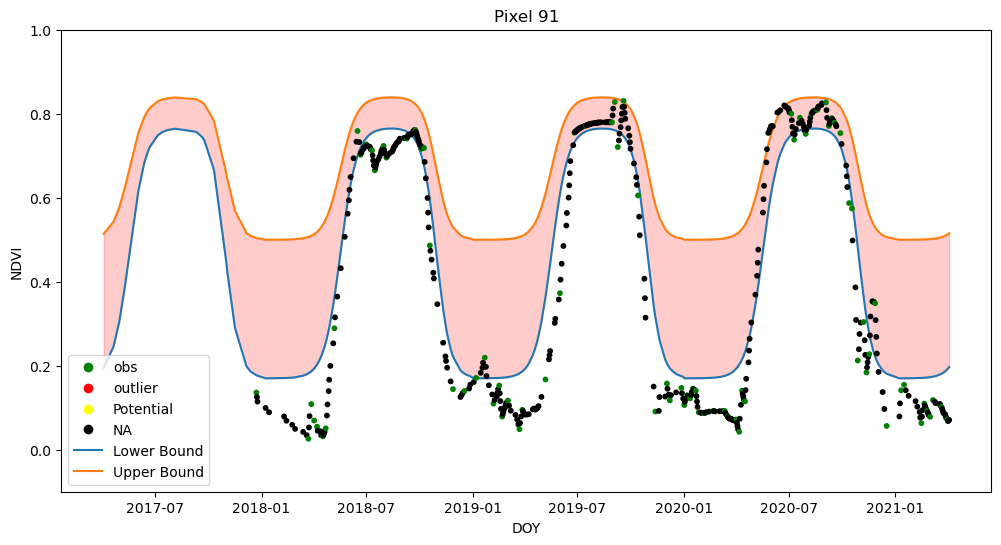

In [6]:
fig, ax = plt.subplots(figsize=(12, 6)) 

start = 0
end = duration_ingestion 

# Map outlier codes to colors
color_dict = {
    0: 'green',   # true
    1: 'red',     # false
    2: 'yellow',  # potential
    3: 'black' ,
    7 : "pink"    # na
}

# Convert new_outlier_list to colors
colors = [color_dict[c] for c in new_outlier_list]

# Plot bounds
ax.plot(dates_sorted[start:end], lower[start:end], label="Lower Bound")
ax.plot(dates_sorted[start:end], upper[start:end], label="Upper Bound")
ax.fill_between(dates_sorted[start:end], lower[start:end], upper[start:end], alpha=0.2, color="red")

ax.scatter(dates_sorted[start:end], flat_array, s=10, color=colors, zorder=3)

# Create legend for outlier categories
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[0], markersize=8, label='obs'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[1], markersize=8, label='outlier'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[2], markersize=8, label='Potential'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[3], markersize=8, label='NA')

]

# Add legend for scatter colors
ax.legend(handles=legend_handles + ax.get_legend_handles_labels()[0])

ax.set_title(f"Pixel {pixel}")
ax.set_ylim(-0.1, 1)
ax.set_xlabel("DOY")
ax.set_ylabel("NDVI")

plt.show()


This chuck creates the GIF so is it possible to visualize the data ingestion step-by-step.
The GIF is saved as separate file to be able to compare more ingestion per pixel

In [7]:
frames = []

new_data_list = [7] * duration_ingestion
new_outlier_list = [7] * duration_ingestion
last_delta = ndvi_sorted[last_position] - median[last_position]

for i in np.arange(starting_pos + 1, duration_ingestion):
    new_data = ndvi_sorted[i]

    if np.isfinite(new_data):
        new_delta = new_data - median[i]
        outlier_new = 0
        
        if (
            (new_data > upper[i] + iqr[i] * param_iqr) or 
            (new_data < lower[i] - iqr[i] * param_iqr)
        ) and (
            (new_delta - last_delta < 0.005) or 
            (new_delta - last_delta > 0.05)
        ):
            outlier_new = 2
            potential_delta = new_delta
            potential_position = i

        if outlier_new == 0:
            potential_outlier_check = new_outlier_list[last_position:i]
            positions = [j for j, x in enumerate(potential_outlier_check) if x == 2]

            if len(positions) == 1:
                pos = positions[0] + last_position
                delta_delta = (new_delta - potential_delta) / (i - potential_position)

                if delta_delta < 0.0005 or delta_delta > 0.005:
                    new_outlier_list[pos] = 1
                else:
                    if i - last_position > 1:
                        slope = (new_delta - last_delta) / (i - last_position)
                        multiplier = np.arange(1, (i - last_position))
                        values = median[last_position + 1:i] + last_delta + slope * multiplier
                        new_data_list[last_position + 1:i] = values

                        new_outlier_list[pos] = 0
                        new_data_list[pos] = ndvi_sorted[pos]
                        last_delta = potential_delta
                        last_position = potential_position

            if i - last_position > 1:
                slope = (new_delta - last_delta) / (i - last_position)
                multiplier = np.arange(1, (i - last_position))
                values = median[last_position + 1:i] + last_delta + slope * multiplier
                new_data_list[last_position + 1:i] = values

            new_data_list[i] = new_data
            last_delta = new_delta
            last_position = i

    else:
        new_data_list[i] = median[i] + last_delta + slope
        outlier_new = 3

    new_outlier_list[i] = outlier_new

    obs_plotted = to_keep[to_keep <=i][2:]

    # ---- Create frame in memory ----
    fig, ax = plt.subplots(figsize=(8, 5))
    current_len = i + 1

    ax.plot(dates_sorted[starting_pos+1:current_len], lower[starting_pos+1:current_len], label="Lower Bound")
    ax.plot(dates_sorted[starting_pos+1:current_len], upper[starting_pos+1:current_len], label="Upper Bound")
    ax.fill_between(dates_sorted[starting_pos+1:current_len], lower[starting_pos+1:current_len], upper[starting_pos+1:current_len], alpha=0.2, color="red")
    ax.scatter(dates_sorted[obs_plotted], ndvi_sorted[obs_plotted], s = 10,color = "green", label = "observed data")

    ax.plot(dates_sorted[starting_pos+1:current_len], new_data_list[starting_pos+1:current_len], color="black", label="Gapfilled NDVI")
    #ax.plot(dates_sorted[:current_len], ndvi_sorted[:current_len], color="gray", linestyle="--", alpha=0.5, label="Original NDVI")

    ax.set_title(f"Pixel {pixel} - Step {i}")
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("DOY")
    ax.set_ylabel("NDVI")
    ax.legend(loc="upper left")
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format="png", dpi=100)
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))
    plt.close()

# ---- Save GIF ----
imageio.mimsave(f"pixel_{pixel}_ndvi_animation.gif", frames, duration=0.05)
print(f"GIF saved to pixel_{pixel}_ndvi_animation.gif")


GIF saved to pixel_91_ndvi_animation.gif
